In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np

In [ ]:
ner_df = pd.read_csv(r'/content/ner_dataset.csv')

UnicodeDecodeError: ignored

In [ ]:
ner_df = pd.read_csv(r'/content/ner_dataset.csv', encoding='unicode_escape')

In [ ]:
ner_df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [ ]:
sentences_words = []
sentences_tags = []
curr_sent_num = -1
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values:
    if isinstance(sent_num, basestring) and 'Sentence: ' in sent_num:
        curr_sent_num = int(sent_num.split(':')[1].strip())

        if current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)

        current_sentence_words = []
        current_sentence_tags = []

    current_sentence_words.append(word.decode(errors='replace'))
    current_sentence_tags.append(tag)

len(sentences_words), len(sentences_tags)

NameError: ignored

In [ ]:
sentences_words = []
sentences_tags = []
curr_sent_num = -1
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values:
    if isinstance(sent_num, (str, bytes)) and 'Sentence: ' in sent_num:
        curr_sent_num = int(sent_num.split(':')[1].strip())

        if current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)

        current_sentence_words = []
        current_sentence_tags = []

    current_sentence_words.append(word)
    current_sentence_tags.append(tag)

len(sentences_words), len(sentences_tags)

(26468, 26468)

In [ ]:
for w, k in zip(sentences_words[123], sentences_tags[123]):
    print(w, k)

Not O
counting O
the O
latest O
death O
, O
the O
World B-org
Health I-org
Organization I-org
says O
227 O
people O
around O
the O
world O
have O
died O
from O
bird O
flu O
since O
2003 B-tim
. O


In [ ]:
train_size = int(len(sentences_words) * 0.8)

train_sentences_words = sentences_words[:train_size]
train_sentences_tags = sentences_tags[:train_size]
test_sentences_words = sentences_words[train_size:]
test_sentences_tags = sentences_tags[train_size:]

print('Train:', len(train_sentences_words), len(train_sentences_tags))
print('Test:', len(test_sentences_words), len(test_sentences_tags))

Train: 21174 21174
Test: 5294 5294


BoW + Cls Benchmark

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import scipy

In [ ]:
def sentence_to_instances(words, tags, bow, count_vectorizer):
    X = []
    y = []
    for w, t in zip(words, tags):
        v = count_vectorizer.transform([w])[0]
        v = scipy.sparse.hstack([v, bow])
        X.append(v)
        y.append(t)

    return scipy.sparse.vstack(X), y

def sentences_to_instances(sentences_words, sentences_tags, count_vectorizer):
    bows = count_vectorizer.transform(map(lambda s: ' '.join(s), sentences_words))
    X = []
    y = []
    for words, tags, bow in zip(sentences_words, sentences_tags, bows):
        sent_X, sent_y = sentence_to_instances(words, tags, bow, count_vectorizer)
        X.append(sent_X)
        y += sent_y

    return scipy.sparse.vstack(X), np.array(y)

In [ ]:
count_vectorizer = CountVectorizer().fit(map(lambda s: ' '.join(s), train_sentences_words))

In [ ]:
train_X, train_y = sentences_to_instances(train_sentences_words, train_sentences_tags, count_vectorizer)
train_X.shape, train_y.shape

((463203, 39070), (463203,))

In [ ]:
test_X, test_y = sentences_to_instances(test_sentences_words, test_sentences_tags, count_vectorizer)
test_X.shape, test_y.shape

((115803, 39070), (115803,))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [ ]:
clf = GradientBoostingClassifier().fit(train_X, train_y)

KeyboardInterrupt: ignored

34m 26s

In [ ]:
predicted = clf.predict(test_X)

In [ ]:
print(classification_report(test_y, predicted))

Prepare for Seq2Seq

In [ ]:
vocab = set(itertools.chain(*[[w for w in s] for s in train_sentences_words]))
tags = set(itertools.chain(*[[w for w in s] for s in train_sentences_tags]))
sentenecs_lens = map(len, train_sentences_words)
len(vocab), len(tags), len(sentenecs_lens)

TypeError: ignored

In [ ]:
vocab = set(itertools.chain(*[[w for w in s] for s in train_sentences_words]))
tags = set(itertools.chain(*[[w for w in s] for s in train_sentences_tags]))
sentenecs_lens = list(map(len, train_sentences_words))
len(vocab), len(tags), len(sentenecs_lens)

(23718, 17, 21174)

(array([6.860e+02, 4.026e+03, 6.956e+03, 6.039e+03, 2.659e+03, 6.410e+02,
        1.310e+02, 2.400e+01, 8.000e+00, 4.000e+00]),
 array([ 1. ,  8.1, 15.2, 22.3, 29.4, 36.5, 43.6, 50.7, 57.8, 64.9, 72. ]),
 <BarContainer object of 10 artists>)

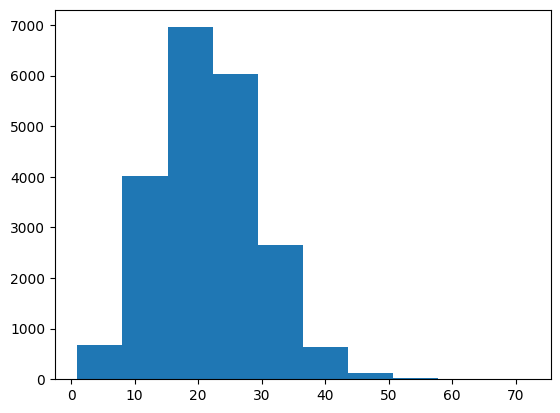

In [ ]:
plt.hist(sentenecs_lens)

In [ ]:
MAX_LEN = 75#max(sentenecs_lens)
VOCAB_SIZE = len(vocab)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
words_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters=[], oov_token='__UNKNOWN__')
words_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_words))
word_index = words_tokenizer.word_index
word_index['__PADDING__'] = 0
index_word = {i:w for w, i in word_index.iteritems()}
print('Unique tokens:', len(word_index))

AttributeError: ignored

In [ ]:
words_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters=[], oov_token='__UNKNOWN__')
words_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_words))
word_index = words_tokenizer.word_index
word_index['__PADDING__'] = 0
index_word = {i:w for w, i in word_index.items()}
print('Unique tokens:', len(word_index))

Unique tokens: 21678


In [ ]:
train_sequences = words_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), train_sentences_words))
test_sequences = words_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), test_sentences_words))

In [ ]:
train_sequences_padded = pad_sequences(train_sequences, maxlen=MAX_LEN)
test_sequences_padded = pad_sequences(test_sequences, maxlen=MAX_LEN)

print(train_sequences_padded.shape, test_sequences_padded.shape)

(21174, 75) (5294, 75)


In [ ]:
tags_tokenizer = Tokenizer(num_words=len(tags), filters='', oov_token='__UNKNOWN__', lower=False)
tags_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_tags))
tag_index = tags_tokenizer.word_index
tag_index['__PADDING__'] = 0
index_tag = {i:w for w, i in tag_index.iteritems()}

index_tag_wo_padding = dict(index_tag)
index_tag_wo_padding[tag_index['__PADDING__']] = '0'
print('Unique tags:', len(tag_index))

AttributeError: ignored

In [ ]:
tags_tokenizer = Tokenizer(num_words=len(tags), filters='', oov_token='__UNKNOWN__', lower=False)
tags_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_tags))
tag_index = tags_tokenizer.word_index
tag_index['__PADDING__'] = 0
index_tag = {i:w for w, i in tag_index.items()}

index_tag_wo_padding = dict(index_tag)
index_tag_wo_padding[tag_index['__PADDING__']] = '0'
print('Unique tags:', len(tag_index))

Unique tags: 19


In [ ]:
train_tags = tags_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), train_sentences_tags))
test_tags = tags_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), test_sentences_tags))

In [ ]:
train_tags_padded = pad_sequences(train_tags, maxlen=MAX_LEN)
test_tags_padded = pad_sequences(test_tags, maxlen=MAX_LEN)

train_tags_padded = np.expand_dims(train_tags_padded, -1)
test_tags_padded = np.expand_dims(test_tags_padded, -1)
print(train_tags_padded.shape, test_tags_padded.shape)

(21174, 75, 1) (5294, 75, 1)


In [ ]:
for w, t in zip(train_sequences_padded[123], train_tags_padded[123]):
    print(index_word[w], index_tag[t[0]])

__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PA

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout
from keras.models import Model
from keras.initializers import Constant

In [ ]:
random_embedding_layer = Embedding(VOCAB_SIZE,
                                300,
                                input_length=MAX_LEN)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = random_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 300)           7115400   
                                                                 
 bidirectional (Bidirection  (None, 75, 128)           186880    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 75, 128)           0         
                                                                 
 dense (Dense)               (None, 75, 32)            4128      
                                                                 
 dense_1 (Dense)             (None, 75, 19)            627       
                                                             

In [ ]:
model.fit(train_sequences_padded, train_tags_padded,
          batch_size=32,
          epochs=10,
          validation_data=(test_sequences_padded, test_tags_padded))

Epoch 1/10
662/662 [==============================] - 42s 46ms/step - loss: 0.1872 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.0601 - val_sparse_categorical_accuracy: 0.9829
Epoch 2/10
662/662 [==============================] - 12s 17ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0485 - val_sparse_categorical_accuracy: 0.9860
Epoch 3/10
662/662 [==============================] - 12s 18ms/step - loss: 0.0321 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.0470 - val_sparse_categorical_accuracy: 0.9864
Epoch 4/10
662/662 [==============================] - 11s 16ms/step - loss: 0.0255 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.0519 - val_sparse_categorical_accuracy: 0.9862
Epoch 5/10
662/662 [==============================] - 11s 16ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.0518 - val_sparse_categorical_accuracy: 0.9860
Epoch 6/10
662/662 [==============================] - 9s 13ms/step - loss: 0.0167 - sparse

Evaluation

In [ ]:
from seqeval.metrics import classification_report, f1_score

ModuleNotFoundError: ignored

In [ ]:
!pip install seqeval

In [ ]:
from seqeval.metrics import classification_report, f1_score

In [ ]:
lstm_predicted = model.predict(test_sequences_padded)

166/166 [==============================] - 2s 8ms/step


In [ ]:
lstm_predicted_tags = []
bow_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = map(index_tag_wo_padding.get,tags)[-len(s):]
    lstm_predicted_tags.append(tags)

    bow_vector, _ = sentences_to_instances([s], [['x']*len(s)], count_vectorizer)
    bow_predicted = clf.predict(bow_vector)[0]
    bow_predicted_tags.append(bow_predicted)

TypeError: ignored

In [ ]:
lstm_predicted_tags = []
bow_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = list(map(index_tag_wo_padding.get,tags))[-len(s):]
    lstm_predicted_tags.append(tags)

    bow_vector, _ = sentences_to_instances([s], [['x']*len(s)], count_vectorizer)
    bow_predicted = clf.predict(bow_vector)[0]
    bow_predicted_tags.append(bow_predicted)

NameError: ignored